### Run these cells in sequential order

In [3]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from skimage.feature import hog
from joblib import dump, load

In [4]:
root = './'
os.chdir(root)
os.listdir()

['407_Bejenariu_David_Cosmin_code.ipynb',
 '.DS_Store',
 'test',
 'test0',
 'model.joblib',
 'submission_files',
 '407_Bejenariu_David_Cosmin_docs.pdf',
 'train',
 'README.txt',
 'processed',
 'board+tokens']

In [5]:
def print_image(img):
    plt.imshow(img)
    plt.show()

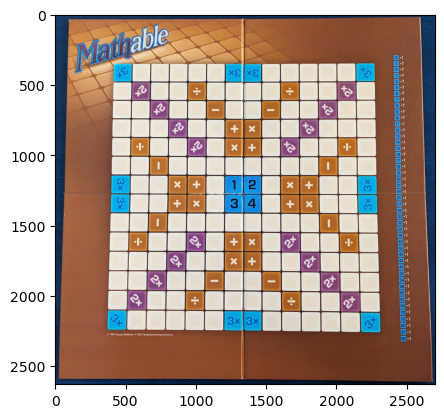

In [6]:
img = cv.imread(f'{root}/board+tokens/board1.jpg')

(h, w) = img.shape[:2]
(cx, cy) = (w // 2, h // 2)
rotation_matrix = cv.getRotationMatrix2D((cx, cy), -3, 1.0)
rotated_img = cv.warpAffine(img, rotation_matrix, (w, h))
cropped_img = rotated_img[270:2900, 720:3420]
width = 2500
height = 2500

print_image(cropped_img)

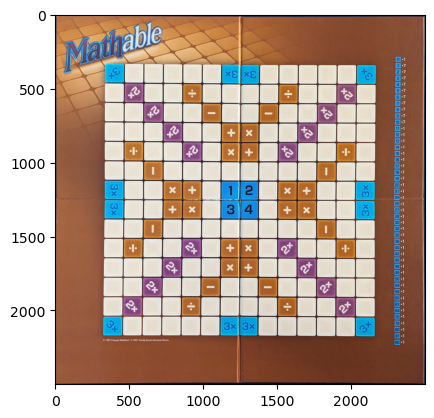

In [7]:
puzzle = np.array([[90, 30], [2600, 5], [2690, 2620], [25, 2595]], dtype='float32')
destination_of_puzzle = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype='float32')
M = cv.getPerspectiveTransform(puzzle, destination_of_puzzle)
model_board = cv.warpPerspective(cropped_img, M, (width, height))

print_image(model_board)

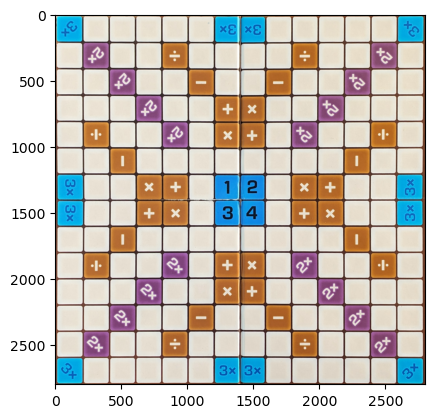

In [8]:
puzzle = np.array([[330, 325], [2175, 335], [2170, 2180], [315, 2175]], dtype='float32')
destination_of_puzzle = np.array([[0, 0], [2800, 0], [2800, 2800], [0, 2800]], dtype='float32')
M = cv.getPerspectiveTransform(puzzle, destination_of_puzzle)
cropped_model_board = cv.warpPerspective(model_board, M, (2800, 2800))

print_image(cropped_model_board)

In [9]:
# find the keypoints and descriptors with SIFT
sift = cv.SIFT_create()
keypoints_model, descriptors_model = sift.detectAndCompute(model_board, None)

def get_warped_target_image(target_image):
    # detect keypoints and extract descriptors from the target image
    keypoints_target, descriptors_target = sift.detectAndCompute(target_image, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(descriptors_model, descriptors_target, k=2)

    # need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]

    # ratio test as per Lowe's paper
    good_matches = []
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            matchesMask[i] = [1, 0]
            good_matches.append(m)

    draw_params = dict(matchColor = (0, 255, 0), singlePointColor = (255, 0, 0), matchesMask = matchesMask, flags = cv.DrawMatchesFlags_DEFAULT)
    img3 = cv.drawMatchesKnn(model_board, keypoints_model, target_image, keypoints_target, matches, None, **draw_params)

    # extract keypoints from good matches
    points_model = np.float32([keypoints_model[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    points_target = np.float32([keypoints_target[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # find homography using RANSAC
    H, _ = cv.findHomography(points_target, points_model, cv.RANSAC)

    warped_target_image = cv.warpPerspective(target_image, H, (model_board.shape[1], model_board.shape[0]))
    return warped_target_image

def get_target_board(target_image_path):
    target_image = cv.imread(target_image_path)

    warped_target_image = get_warped_target_image(target_image)
    puzzle = np.array([[330, 325], [2175, 335], [2170, 2180], [315, 2175]], dtype='float32')
    destination_of_puzzle = np.array([[0, 0], [2800, 0], [2800, 2800], [0, 2800]], dtype='float32')
    M = cv.getPerspectiveTransform(puzzle, destination_of_puzzle)
    target_board = cv.warpPerspective(warped_target_image, M, (2800, 2800))

    return target_board

In [10]:
def get_lines(size):
    vertical_lines = []
    horizontal_lines = []

    for i in range(0, size + 1, size // 14):
        vertical_lines.append([(i, 0), (i, size - 1)])
        horizontal_lines.append([(0, i), (size - 1, i)])

    return vertical_lines, horizontal_lines

def compare_hue(image1, image2):
    hsv_image1 = cv.cvtColor(image1, cv.COLOR_BGR2HSV)
    hsv_image2 = cv.cvtColor(image2, cv.COLOR_BGR2HSV)
    hue_channel1 = hsv_image1[:, :, 0]
    hue_channel2 = hsv_image2[:, :, 0]

    hist1, _ = np.histogram(hue_channel1, bins=180, range=[0, 180])
    hist2, _ = np.histogram(hue_channel2, bins=180, range=[0, 180])
    hist1 = hist1.astype(float) / np.sum(hist1)
    hist2 = hist2.astype(float) / np.sum(hist2)

    intersection = np.minimum(hist1, hist2).sum()
    return intersection

def get_configuration(image_path, previous_board, occupied, train=False, ans=None):
    target_board = get_target_board(image_path)
    vertical_lines, horizontal_lines = get_lines(2800)

    matrix = np.empty((14, 14), dtype='U2')
    hue_intersection = np.empty((14, 14), dtype='float')
    patches = []
    labels = []

    if train:
        f = open(ans, 'r')
        token = f.readline().split()[-1]

    for i in range(len(horizontal_lines) - 1):
        for j in range(len(vertical_lines) - 1):
            y_min = vertical_lines[j][0][0] + 20
            y_max = vertical_lines[j + 1][1][0] - 20
            x_min = horizontal_lines[i][0][1] + 20
            x_max = horizontal_lines[i + 1][1][1] - 20

            patch = target_board[x_min:x_max, y_min:y_max].copy()
            previous_patch = previous_board[x_min:x_max, y_min:y_max].copy()
            hue_intersection[i][j] = compare_hue(patch, previous_patch)

    min_index = np.unravel_index(np.argmin(hue_intersection), hue_intersection.shape)

    for i in range(len(horizontal_lines) - 1):
        for j in range(len(vertical_lines) - 1):
            y_min = vertical_lines[j][0][0] + 20
            y_max = vertical_lines[j + 1][1][0] - 20
            x_min = horizontal_lines[i][0][1] + 20
            x_max = horizontal_lines[i + 1][1][1] - 20

            patch = target_board[x_min:x_max, y_min:y_max].copy()

            if (i, j) == min_index:
                if train:
                    patches.append(get_hog_descriptors(patch))

                if (i, j) not in occupied:
                    if train:
                        matrix[i][j] = token
                    else:
                        test_patch = get_hog_descriptors(patch)
                        test_i = i
                        test_j = j
                        matrix[i][j] = 'to be predicted'
                else:
                    matrix[i][j] = occupied[(i, j)]

                labels.append(matrix[i][j])
            else:
                matrix[i][j] = '#'

    if train:
        return matrix, patches, labels, target_board
    else:
        return matrix, np.array([test_patch]), test_i, test_j, target_board

In [11]:
def get_hog_descriptors(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    return hog(
        image,
        pixels_per_cell=(5, 5),
        orientations=9,
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        feature_vector=True
    )

In [12]:
model = load(f'{root}/model.joblib')

In [23]:
def generate_annotations(model):
    results_path = f'{root}/submission_files/407_Bejenariu_David_Cosmin'
    if not os.path.exists(results_path):
        os.makedirs(results_path)

    previous_board = cropped_model_board
    for game in range(4, 5):
        occupied = {}
        for turn in range(32, 51):
            print(f'turn:{turn}')
            if turn < 10:
                path = f'{game}_0{turn}'
            else:
                path = f'{game}_{turn}'

            matrix, patch, row, column, previous_board = get_configuration(f'{root}/test/{path}.jpg', previous_board, occupied)
            token = model.predict(patch)
            print(token)

            for i in range(14):
                for j in range(14):
                    if matrix[i][j] != '#' and (i, j) not in occupied:
                        occupied[(i, j)] = matrix[i][j]

            with open(f'{results_path}/{path}.txt', 'w') as f:
                f.write(f'{row + 1}{chr(65 + column)} {token[0]}')

        scores = open(f'{results_path}/{game}_scores.txt', 'w')
        scores.close()

In [24]:
generate_annotations(model)

turn:32
[1]
turn:33
[1]
turn:34
[8]
turn:35
[10]
turn:36
[4]
turn:37
[2]
turn:38
[7]
turn:39
[5]
turn:40
[35]
turn:41
[3]
turn:42
[7]
turn:43
[11]
turn:44
[2]
turn:45
[60]
turn:46
[10]
turn:47
[4]
turn:48
[9]
turn:49
[4]
turn:50
[8]


### Cells used for training the model. Don't run

In [ ]:
def get_train_data():
    train_patches = []
    train_labels = []
    previous_board = cropped_model_board

    for game in range(1, 5):
        occupied = {}
        print(f'game:{game}')

        for turn in range(1, 51):
            print(turn)
            if turn < 10:
                path = f'{root}/train/{game}_0{turn}'
            else:
                path = f'{root}/train/{game}_{turn}'

            matrix, patches, labels, previous_board = get_configuration(f'{path}.jpg', previous_board, occupied, train=True, ans=f'{path}.txt')

            for i in range(14):
                for j in range(14):
                    if matrix[i][j] != '#' and (i, j) not in occupied:
                        occupied[(i, j)] = matrix[i][j]

            train_patches += patches
            train_labels += labels

    train_patches = np.array(train_patches)
    train_labels = np.array(train_labels)

    return train_patches, train_labels

In [ ]:
def get_auxiliary_train_data():
    train_tokens = []

    for i in range(552):
        token = cv.imread(f'{root}/train-patches/{i}.jpg')
        train_tokens.append(get_hog_descriptors(token))

    with open(f'{root}/train-patches/tokens.txt', 'r') as f:
        train_labels = f.read().split('\n')
        if train_labels[-1] == '':
            train_labels.pop()

    return np.array(train_tokens), np.array(train_labels).astype(int)

x_aux, y_aux = get_auxiliary_train_data()
y_aux

In [ ]:
x_train, y_train = get_train_data()
x_train = np.concatenate((x_train, x_aux), axis=0)
y_train = np.concatenate((y_train.astype(int), y_aux))

model = SVC(C=10, kernel='linear')
model.fit(x_train, y_train)

dump(model, f'{root}/model.joblib')